# 데이터 살펴보기

In [ ]:
# 필요한 라이브러리
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.stats import shapiro

# 데이터 불러오기
sehee_file = 'accepted_2007_to_2018Q4.csv'
sumin_file = 'accepted_2007_to_2018Q4 2.csv'
cleaned_file = 'acc_cleaned.csv'
acc = pd.read_csv(sehee_file)

print(acc.shape)
acc.head()

FileNotFoundError: [Errno 2] No such file or directory: 'accepted_2007_to_2018Q4.csv'

In [36]:
# 대출상환 항목 3개만 남기기
## acc = 대출상환목록 3개로 정리
acc= acc[acc['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])].copy()

In [37]:
# 대출상환 항목 0,1로 인코딩
status_map = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Default': 1
}
acc['loan_status'] = acc['loan_status'].map(status_map)

In [38]:
# null 값이 80% 이상인 컬럼 삭제
## acc = 대출상환목록 3개로 정리, Null 값이 80% 이상인 컬럼 삭제

threshold = acc.shape[0] * 0.8               # 기준 만들고
cols_to_drop = acc.columns[acc.isnull().sum() > threshold]  # 조건에 맞는 컬럼 추출
acc = acc.drop(columns=cols_to_drop)          # 해당 컬럼 삭제

In [39]:
# 논문 참고하여 칼럼 셀렉
## acc = 대출상환목록 3개로 정리, 
#        Null 값이 80% 이상인 컬럼 삭제,
#        중요 칼럼만 남김,

columns_to_keep = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade',
    'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
    'verification_status', 'purpose', 'dti', 'open_acc', 'revol_bal',
    'revol_util', 'total_acc', 'loan_status', 'pub_rec',
    'pub_rec_bankruptcies', 'mort_acc', 'inq_last_6mths',
    'inq_last_12m', 'num_bc_tl', 'num_actv_bc_tl'
]

acc = acc[columns_to_keep]

In [40]:
# 숫자형
acc.select_dtypes(include='number').columns

# 범주형
acc.select_dtypes(exclude='number').columns

Index(['term', 'grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'purpose'],
      dtype='object')

## 데이터 분포 살펴보기

In [41]:
# na 제외한 문자열 소문자 변환 + 앞뒤 공백제거
acc['emp_title'] = acc['emp_title'].apply(
    lambda x: x.lower().strip() if pd.notnull(x) else x
)

loan_amnt skewness: 0.7824983744130591
int_rate skewness: 0.7134897274225662
installment skewness: 1.006541533525739


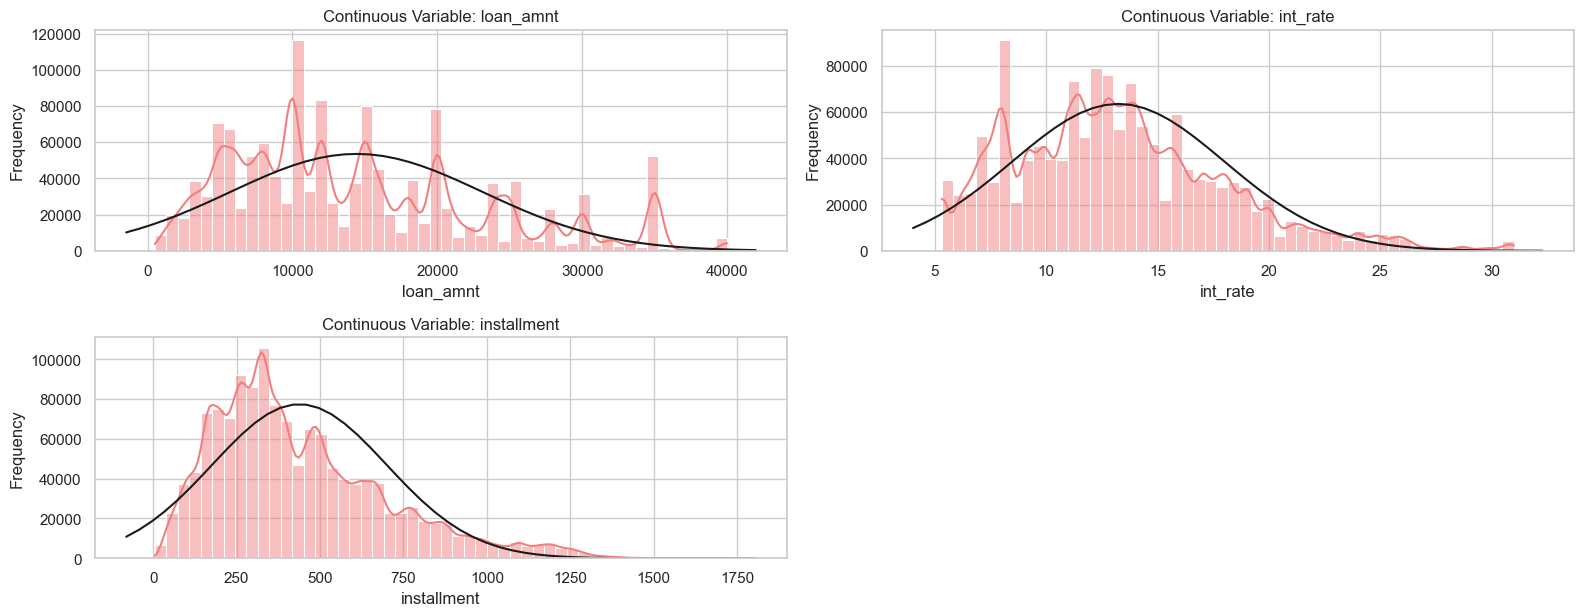

In [42]:
# 변수 분류
categorical_vars = acc.iloc[:, :6].select_dtypes(include='object').columns.to_list()
continuous_vars = acc.iloc[:, :6].select_dtypes(exclude='object').columns.to_list()

# 시각화 스타일
sns.set_theme(style="whitegrid") # set -> set_theme
plt.figure(figsize=(16, 12))

for i, var in enumerate(continuous_vars):
    plt.subplot(4, 2, i + 1)
    # 데이터 분포 히스토그램
    sns.histplot(acc.iloc[:, :6][var], kde=True, color='lightcoral', bins=50)

    # 왜도 출력
    print(f'{var} skewness:', stats.skew(acc.iloc[:, :6][var]))

    # 정규분포 곡선 추가 (히스토그램 기준에 맞게 스케일링)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 50)
    mean = acc.iloc[:, :6][var].mean()
    std = acc.iloc[:, :6][var].std()
    pdf = stats.norm.pdf(x, mean, std)
    
    bin_width = (xmax - xmin) / 50
    pdf_scaled = pdf * len(acc.iloc[:, :6][var]) * bin_width  # 스케일 조정

    plt.plot(x, pdf_scaled, 'k', linewidth=1.5)
    plt.title(f'Continuous Variable: {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('image/histogram_0~5_cn.png', dpi=150)
plt.show()

In [ ]:
# 
for var in continuous_vars:
    stat, pvalue = stats.shapiro(sehee_check[var])
    t = '기각' if pvalue < 0.05 else '귀무가설 채택'
    print(f'{var} shapiro: stats - {stat} pvalue - {pvalue} 기각여부 - {t}')

## 여기서부터 은서님 하시면 됩니다!!

In [ ]:

# [1] 수치형 변수 결측치 확인 및 로그 변환 + 정규성 검정 (dti, annual_inc)
num_cols = ['dti', 'annual_inc']

for col in num_cols:
    print(f"\n===== 수치형 변수: {col} =====")
    
    # 결측치 확인
    missing_count = acc[col].isnull().sum()
    total_count = acc.shape[0]
    missing_ratio = missing_count / total_count * 100
    print(f"결측치 수: {missing_count}개, 전체: {total_count}개, 결측치 비율: {missing_ratio:.4f}%")
    
    # 로그 변환: log(1+x)로 0 처리
    acc[f'{col}_log'] = np.log1p(acc[col])

    # 히스토그램 + KDE (로그 변환된 데이터)
    plt.figure(figsize=(7, 4))
    sns.histplot(acc[f'{col}_log'].dropna(), bins=50, kde=True)
    plt.title(f'{col}_log 히스토그램 + KDE')
    plt.xlabel(f'log({col} + 1)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    

    # Q-Q plot (원본 데이터 사용)
    stats.probplot(acc[col].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q plot of {col}")
    plt.tight_layout()
    plt.show()

    # Shapiro-Wilk 정규성 검정 (최대 5000 샘플링)
    sample = acc[col].dropna()
    if len(sample) > 5000:
        sample = sample.sample(5000, random_state=42)
    stat, p = shapiro(sample)
    print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")
    if p < 0.05:
        print("→ 정규성을 따르지 않음")
    else:
        print("→ 정규성을 만족함")

## 여기서부터 수지님 하시면 됩니다!!

In [ ]:
# 폰트 설정 (OS별로 다름)
plt.rc('font', family='Malgun Gothic') 

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 1. open_acc 개설된 신용 계좌수 p-value

stat, p = shapiro(acc['open_acc'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

In [ ]:
acc_log = acc[['open_acc']].dropna()

# 로그 변환 적용
acc_log['open_acc_log'] = np.log1p(acc_log['open_acc'])

# ----------------- 시각화 코드 -----------------

plt.figure(figsize=(10, 5))

# 변환 전 원본 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(acc_log['open_acc'], kde=True)
plt.title('변환 전 (Original) 분포')
plt.xlabel('개설된 신용계좌 수 (원본)')

# 변환 후 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(acc_log['open_acc_log'], kde=True)
plt.title('로그 변환 후 개설된 신용계좌 수 분포')
plt.xlabel('개설된 신용계좌 수 (로그 변환 후)')

plt.tight_layout()
plt.show()

In [ ]:
# 2. revol_bal 리볼빙 대출 잔액 p-value
stat, p = shapiro(acc['revol_bal'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

In [ ]:
acc_log = acc[['revol_bal']].dropna()

# 로그 변환 적용
acc_log['revol_bal_log'] = np.log1p(acc_log['revol_bal'])

# ----------------- 시각화 코드 -----------------

plt.figure(figsize=(10, 5))

# 변환 전 원본 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(acc_log['revol_bal'], kde=True)
plt.title('변환 전 (Original) 분포')
plt.xlabel('리볼빙 대출 잔액 (원본)')

# 변환 후 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(acc_log['revol_bal_log'], kde=True)
plt.title('로그 변환 후 리볼빙 대출 잔액 분포')
plt.xlabel('리볼빙 대출 잔액 (로그 변환 후)')

plt.tight_layout()
plt.show()

In [ ]:
# 3. revol_util 리볼빙 대출 사용률 p-value

stat, p = shapiro(acc['revol_util'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

In [ ]:
acc_log = df[['revol_util']].dropna()

# 로그 변환 적용
acc_log['revol_util_log'] = np.log1p(acc_log['revol_util'])

# ----------------- 시각화 코드 -----------------

plt.figure(figsize=(10, 5))

# 변환 전 원본 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(acc_log['revol_util'], kde=True)
plt.title('변환 전 (Original) 분포')
plt.xlabel(' 리볼빙 대출 사용률 (원본)')

# 변환 후 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(acc_log['revol_util_log'], kde=True)
plt.title('로그 변환 후 리볼빙 대출 사용률 분포')
plt.xlabel(' 리볼빙 대출 사용률 (로그 변환 후)')

plt.tight_layout()
plt.show()

In [ ]:
# 4. total_acc 전체 신용계좌 수 p-value

stat, p = shapiro(acc['total_acc'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

In [ ]:
acc_log = acc[['total_acc']].dropna()

# 로그 변환 적용
acc_log['total_acc_log'] = np.log1p(acc_log['total_acc'])

# ----------------- 시각화 코드 -----------------

plt.figure(figsize=(10, 5))

# 변환 전 원본 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(acc_log['total_acc'], kde=True)
plt.title('변환 전 (Original) 분포')
plt.xlabel(' 전체 신용계좌 수 (원본)')

# 변환 후 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(acc_log['total_acc_log'], kde=True)
plt.title('로그 변환 후 전체 신용계좌 수 분포')
plt.xlabel(' 전체 신용계좌 수 (로그 변환 후)')

plt.tight_layout()
plt.show()

In [ ]:
# 5. loan_status 대출 상태 p-value
stat, p = shapiro(acc['loan_status'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

In [ ]:
# loan_status 대출 상태
plt.figure(figsize=(10, 6))
sns.histplot(acc['loan_status'], kde=True)
plt.title('대출 상태 분포')
plt.xlabel('대출 상태')
plt.ylabel('빈도')
plt.show()

In [ ]:
# 6. pub_rec 공공기록(파산) p-value
stat, p = shapiro(acc['pub_rec'].dropna())

print(f"Shapiro-Wilk 검정 p-value: {p:.4f}")

if p > 0.05:
    print("p-값이 0.05보다 크므로, 데이터는 정규분포를 따른다고 볼 수 있습니다.")
else:
    print("p-값이 0.05 이하이므로, 데이터는 정규분포를 따르지 않습니다.")

In [ ]:
acc_log = acc[['pub_rec']].dropna()

# 로그 변환 적용
acc_log['pub_rec_log'] = np.log1p(acc_log['pub_rec'])

# ----------------- 시각화 코드 -----------------

plt.figure(figsize=(10, 5))

# 변환 전 원본 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(acc_log['pub_rec'], kde=True)
plt.title('변환 전 (Original) 분포')
plt.xlabel(' 공공기록(파산) (원본)')

# 변환 후 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(acc_log['pub_rec_log'], kde=True)
plt.title('공공기록(파산) 분포')
plt.xlabel(' 공공기록(파산) (로그 변환 후)')

plt.tight_layout()
plt.show()

## 여기서부터 수민님 하시면 됩니다!!

## 숫자형 변수들 이상치 살펴보기

In [292]:
# dti 의 이상치 개수 5473 _ IQR 사용 
# 이상치 제거 예정

Q1 = acc['dti'].quantile(0.25)
Q3 = acc['dti'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_dti = acc[(acc['dti'] < lower_bound) | (acc['dti'] > upper_bound)]

print('이상치 개수: ' , len(outliers_dti))
print('해당 칼럼 전체 개수: ', len(acc.dti))
print('이상치 비율: ', round(len(outliers_dti) / len(acc.dti) * 100 , 2), '%' )


이상치 개수:  5473
해당 칼럼 전체 개수:  1345350
이상치 비율:  0.41 %


In [293]:
# revol_util 이상치
# 이상치 제거 예정

Q1 = acc['revol_util'].quantile(0.25)
Q3 = acc['revol_util'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_revol_util = acc[(acc['revol_util'] < lower_bound) | (acc['revol_util'] > upper_bound)]

print('이상치 개수: ' , len(outliers_revol_util))
print('해당 칼럼 전체 개수: ', len(acc.revol_util))
print('이상치 비율: ', round(len(outliers_revol_util) / len(acc.revol_util) * 100 , 2), '%' )


이상치 개수:  72
해당 칼럼 전체 개수:  1345350
이상치 비율:  0.01 %


In [294]:
# pub_rec_bankruptcies(파산 기록수) 이상치
# 이상치 편집 예정

Q1 = acc['pub_rec_bankruptcies'].quantile(0.25)
Q3 = acc['pub_rec_bankruptcies'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_rec_bnkrcys = acc[(acc['pub_rec_bankruptcies'] < lower_bound) | (acc['pub_rec_bankruptcies'] > upper_bound)]

print('이상치 개수: ' , len(outliers_rec_bnkrcys))
print('해당 칼럼 전체 개수: ', len(acc.pub_rec_bankruptcies))
print('이상치 비율: ', round(len(outliers_rec_bnkrcys) / len(acc.pub_rec_bankruptcies) * 100 , 2), '%' )

이상치 개수:  167666
해당 칼럼 전체 개수:  1345350
이상치 비율:  12.46 %


In [295]:
# mort_acc 이상치
# 이상치 제거 예정

Q1 = acc['mort_acc'].quantile(0.25)
Q3 = acc['mort_acc'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_mort_acc = acc[(acc['mort_acc'] < lower_bound) | (acc['mort_acc'] > upper_bound)]

print('이상치 개수: ' , len(outliers_mort_acc))
print('해당 칼럼 전체 개수: ', len(acc.mort_acc))
print('이상치 비율: ', round(len(outliers_mort_acc) / len(acc.mort_acc) * 100 , 2), '%' )

이상치 개수:  17794
해당 칼럼 전체 개수:  1345350
이상치 비율:  1.32 %


In [296]:
# inq_last_12m 이상치
# 이상치 제거 예정

Q1 = acc['inq_last_12m'].quantile(0.25)
Q3 = acc['inq_last_12m'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_inq_last_12m = acc[(acc['inq_last_12m'] < lower_bound) | (acc['inq_last_12m'] > upper_bound)]

print('이상치 개수: ' , len(outliers_inq_last_12m))
print('해당 칼럼 전체 개수: ', len(acc.inq_last_12m))
print('이상치 비율: ', round(len(outliers_inq_last_12m) / len(acc.inq_last_12m) * 100 , 2), '%' )

이상치 개수:  34344
해당 칼럼 전체 개수:  1345350
이상치 비율:  2.55 %


In [297]:
# num_bc_tl 이상치
# 이상치 제거 예정

Q1 = acc['num_bc_tl'].quantile(0.25)
Q3 = acc['num_bc_tl'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_num_bc_tl = acc[(acc['num_bc_tl'] < lower_bound) | (acc['num_bc_tl'] > upper_bound)]

print('이상치 개수: ' , len(outliers_num_bc_tl))
print('해당 칼럼 전체 개수: ', len(acc.num_bc_tl))
print('이상치 비율: ', round(len(outliers_num_bc_tl) / len(acc.num_bc_tl) * 100 , 2), '%' )

이상치 개수:  27144
해당 칼럼 전체 개수:  1345350
이상치 비율:  2.02 %


In [298]:
# num_actv_bc_tl 이상치
# 이상치 제거 예정

Q1 = acc['num_actv_bc_tl'].quantile(0.25)
Q3 = acc['num_actv_bc_tl'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치만 추출
outliers_num_actv_bc_tl = acc[(acc['num_actv_bc_tl'] < lower_bound) | (acc['num_actv_bc_tl'] > upper_bound)]

print('이상치 개수: ' , len(outliers_num_actv_bc_tl))
print('해당 칼럼 전체 개수: ', len(acc.num_actv_bc_tl))
print('이상치 비율: ', round(len(outliers_num_actv_bc_tl) / len(acc.num_actv_bc_tl) * 100 , 2), '%' )

이상치 개수:  26648
해당 칼럼 전체 개수:  1345350
이상치 비율:  1.98 %


In [299]:
# 이상치 지울 데이터 따로 만들기
## acc_ver2 = 대출상환목록 3개로 정리, 
#             Null 값이 80% 이상인 컬럼 삭제,
#             중요 칼럼만 남김,
acc_ver2 = acc.copy()

In [300]:
### ver2 데이터에서 이상치 모두 제거하기

## acc_ver2 = 대출상환목록 3개로 정리, 
#             Null 값이 80% 이상인 컬럼 삭제,
#             중요 칼럼만 남김,

## acc_cleaned = 대출상환목록 3개로 정리, 
#                Null 값이 80% 이상인 컬럼 삭제,
#                중요 칼럼만 남김,
#                미미한 이상치들 제거


# 이상치 하나로 모으기                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
outliers_all = [outliers_dti,
    outliers_revol_util,
    outliers_mort_acc,
    outliers_inq_last_12m,
    outliers_num_bc_tl,
    outliers_num_actv_bc_tl
]

# 이상치 데이터 하나로 합치기
outliers_all = pd.concat(outliers_all)

# 중복된 인덱스 제거 (선택사항이지만 코드 정돈을 위해)
outliers_all = outliers_all[~outliers_all.index.duplicated(keep='first')]

# 기존 데이터(acc_ver2)에서 이상치 제거한 새 데이터 만들기
acc_cleaned = acc_ver2.drop(index=outliers_all.index).reset_index(drop=True)

# 이상치 제거 후 null 값 개수 확인
acc.select_dtypes(include='number').isnull().sum()



loan_amnt                    0
int_rate                     0
installment                  0
annual_inc                   0
dti                        374
open_acc                     0
revol_bal                    0
revol_util                 857
total_acc                    0
loan_status                  0
pub_rec                      0
pub_rec_bankruptcies       697
mort_acc                 47281
inq_last_6mths               1
inq_last_12m            807715
num_bc_tl                67527
num_actv_bc_tl           67527
dtype: int64

## Null 값 하나씩 뜯어보기

In [301]:
dti_rate = round(acc_cleaned.dti.isnull().sum() / acc_cleaned.dti.shape[0] * 100 ,5)
print('dti null 값 비율: ' , dti_rate)
revol_util_rate = round(acc_cleaned.revol_util.isnull().sum() / acc_cleaned.revol_util.shape[0] * 100 ,5)
print('revol_util null 값 비율: ' , revol_util_rate)
pub_rec_bankruptcies_rate = round(acc_cleaned.pub_rec_bankruptcies.isnull().sum() / acc_cleaned.pub_rec_bankruptcies.shape[0] * 100 ,5)
print('pub_rec_bankruptcies null 값 비율: ' , pub_rec_bankruptcies_rate)
mort_acc_rate = round(acc_cleaned.mort_acc.isnull().sum() / acc_cleaned.mort_acc.shape[0] * 100 ,5)
print('mort_acc null 값 비율: ' , mort_acc_rate)
inq_last_12m_rate = round(acc_cleaned.inq_last_12m.isnull().sum() / acc_cleaned.inq_last_12m.shape[0] * 100 ,5)
print('inq_last_12m null 값 비율: ' , inq_last_12m_rate)
num_bc_tl_rate = round(acc_cleaned.num_bc_tl.isnull().sum() / acc_cleaned.num_bc_tl.shape[0] * 100 ,5)
print('num_bc_tl null 값 비율: ' , num_bc_tl_rate)
num_actv_bc_tl_rate = round(acc_cleaned.num_actv_bc_tl.isnull().sum() / acc_cleaned.num_actv_bc_tl.shape[0] * 100 ,5)
print('num_actv_bc_tl null 값 비율: ' , num_actv_bc_tl_rate)

dti null 값 비율:  0.02834
revol_util null 값 비율:  0.06584
pub_rec_bankruptcies null 값 비율:  0.05596
mort_acc null 값 비율:  3.79627
inq_last_12m null 값 비율:  61.66024
num_bc_tl null 값 비율:  5.3887
num_actv_bc_tl null 값 비율:  5.3887


In [302]:
# dti NA들이 연간 소득 0인 거랑 연관있는지 확인
print(acc_cleaned[acc_cleaned['annual_inc']==0].shape[0])
print(acc_cleaned.loc[acc_cleaned['annual_inc']==0, 'dti'].unique())
print(acc_cleaned[(acc_cleaned['annual_inc'] == 0) & (acc_cleaned['verification_status'] == 'Not Verified')].shape[0])
# 관련 존재! 연간 소득 0이면 dti NA임
acc_cleaned[(acc_cleaned['annual_inc']!=0) & (acc_cleaned['dti'].isnull())] # 연간 소득이 1 or 2
# 351

342
[nan]
319


,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,revol_util,total_acc,loan_status,pub_rec,pub_rec_bankruptcies,mort_acc,inq_last_6mths,inq_last_12m,num_bc_tl,num_actv_bc_tl
371239,6000.0,36 months,10.42,194.79,B,NaN,NaN,MORTGAGE,1.0,Not Verified,...,20.4,17.0,0,0.0,0.0,2.0,0.0,2.0,4.0,3.0
374169,40000.0,60 months,12.62,902.37,C,NaN,NaN,MORTGAGE,1.0,Not Verified,...,72.7,24.0,0,0.0,0.0,4.0,0.0,0.0,6.0,4.0
377231,11000.0,36 months,10.91,359.66,B,NaN,NaN,MORTGAGE,1.0,Not Verified,...,34.3,15.0,0,0.0,0.0,0.0,0.0,1.0,4.0,3.0
449882,2400.0,36 months,11.47,79.11,B,NaN,NaN,RENT,1.0,Not Verified,...,53.8,21.0,1,0.0,0.0,0.0,1.0,1.0,7.0,3.0
536730,24000.0,36 months,8.39,756.40,B,NaN,NaN,MORTGAGE,1.0,Not Verified,...,54.8,11.0,0,0.0,0.0,1.0,0.0,1.0,7.0,3.0
565842,18000.0,60 months,16.29,440.51,D,NaN,NaN,MORTGAGE,1.0,Not Verified,...,31.9,23.0,1,1.0,1.0,1.0,0.0,2.0,8.0,2.0
836963,8000.0,36 months,25.81,321.52,E,NaN,NaN,MORTGAGE,1.0,Not Verified,...,73.5,28.0,1,0.0,0.0,1.0,0.0,1.0,8.0,2.0
1175584,15000.0,36 months,10.91,490.45,B,RN,10+ years,RENT,2.0,Not Verified,...,67.6,24.0,0,0.0,0.0,3.0,1.0,1.0,7.0,1.0
1190155,3600.0,36 months,14.08,123.18,C,NaN,NaN,RENT,1.0,Verified,...,19.2,16.0,0,0.0,0.0,0.0,1.0,1.0,6.0,3.0
1193187,40000.0,60 months,9.93,848.51,B,Admin,< 1 year,MORTGAGE,1.0,Not Verified,...,24.3,11.0,0,0.0,0.0,0.0,1.0,1.0,7.0,4.0


In [303]:
# # 리볼빙 신용 총 한도 - total_rev_hi_lim 칼럼 있어야 확인 가능
# print(acc_cleaned[(acc_cleaned['total_rev_hi_lim'] == 0) | (acc_cleaned['total_rev_hi_lim'].isnull())].shape[0])
# print('리볼빙 신용 총 한도가 0인 데이터 수', acc_cleaned[(acc_cleaned['total_rev_hi_lim'] == 0)].shape[0], '\n 총 한도가 na인 데이터 수' , acc_cleaned[acc_cleaned['total_rev_hi_lim'].isnull()].shape[0])
# # 리볼빙 신용 총 한도 == 0 이면서 revol_util NA
# print(acc_cleaned[(acc_cleaned['total_rev_hi_lim'] == 0) & (acc_cleaned['revol_util'].isnull())].shape[0])
# print(acc_cleaned[(acc_cleaned['total_rev_hi_lim'].isnull()) & (acc_cleaned['revol_util'].isnull())].shape[0])
# acc_cleaned.loc[((acc_cleaned['total_rev_hi_lim'] != 0 ) & (acc_cleaned['total_rev_hi_lim'].notna())) & (acc_cleaned['revol_util'].isnull()), 'revol_util':'total_rev_hi_lim']

In [304]:
# 파산 기록 NA 값 확인
print(acc_cleaned[acc_cleaned['pub_rec_bankruptcies'] >= 0].shape[0])
print(acc_cleaned.loc[(acc_cleaned['pub_rec'].notnull()) & (acc_cleaned['pub_rec_bankruptcies'].isnull()), ['pub_rec', 'pub_rec_bankruptcies', 'verification_status']])
print(acc_cleaned.loc[(acc_cleaned['pub_rec'] == 0) & (acc_cleaned['pub_rec_bankruptcies'].isnull())].shape[0])
print(acc_cleaned.loc[(acc_cleaned['pub_rec'] == 0) & (acc_cleaned['pub_rec_bankruptcies'].isnull()), ['pub_rec', 'pub_rec_bankruptcies', 'verification_status']].value_counts('verification_status'))
print(acc_cleaned.loc[(acc_cleaned['pub_rec'] != 0) & (acc_cleaned['pub_rec_bankruptcies'].isnull())])

1244762
        pub_rec  pub_rec_bankruptcies verification_status
884238      0.0                   NaN        Not Verified
884290      0.0                   NaN        Not Verified
884594      0.0                   NaN        Not Verified
887675      0.0                   NaN            Verified
887949      0.0                   NaN        Not Verified
...         ...                   ...                 ...
888944      0.0                   NaN        Not Verified
888945      0.0                   NaN        Not Verified
888946      0.0                   NaN        Not Verified
888947      0.0                   NaN        Not Verified
888948      0.0                   NaN        Not Verified

[697 rows x 3 columns]
677
verification_status
Not Verified    676
Verified          1
Name: count, dtype: int64
        loan_amnt        term  int_rate  installment grade  \
888247     7000.0   36 months     11.34       230.30     C   
888261    10000.0   36 months     13.24       338.10     D

In [305]:
# mort_acc - 모기지 대출 계좌수
print(acc_cleaned[acc_cleaned['mort_acc'] >= 0].shape[0]) # 0 존재
print(acc_cleaned[(acc_cleaned['home_ownership'] == 'NONE') & (acc_cleaned['mort_acc'].isnull())])
print(acc_cleaned[(acc_cleaned['home_ownership'] == 'MORTGAGE') & (acc_cleaned['mort_acc'].isnull())].shape[0])
print(acc_cleaned[(acc_cleaned['home_ownership'] == 'MORTGAGE') & (acc_cleaned['mort_acc'].isnull())].value_counts(['verification_status']))
print(acc_cleaned[(acc_cleaned['home_ownership'].isin(['RENT', 'OWN', 'ANY', 'OTHER'])) & (acc_cleaned['mort_acc'].isnull())].value_counts(['home_ownership', 'verification_status']))


1198178
        loan_amnt        term  int_rate  installment grade emp_title  \
888550    10000.0   36 months      7.75       312.22     A       ups   
888891     4000.0   36 months      9.64       128.41     B       NaN   
888892     2800.0   36 months      8.70        88.65     B       NaN   

       emp_length home_ownership  annual_inc verification_status  ...  \
888550    5 years           NONE     22200.0        Not Verified  ...   
888891   < 1 year           NONE    100000.0        Not Verified  ...   
888892   < 1 year           NONE    120000.0        Not Verified  ...   

       revol_util  total_acc  loan_status  pub_rec  pub_rec_bankruptcies  \
888550        8.7       22.0            0      0.0                   NaN   
888891       14.9        8.0            0      0.0                   NaN   
888892       14.9        8.0            0      0.0                   NaN   

        mort_acc  inq_last_6mths  inq_last_12m  num_bc_tl  num_actv_bc_tl  
888550       NaN             

In [306]:
acc_cleaned.groupby('home_ownership')['mort_acc'].agg(['mean', 'median'])

,mean,median
home_ownership,,
ANY,1.459459,1.0
MORTGAGE,2.472820,2.0
NONE,1.720930,1.0
OTHER,1.534884,1.0
OWN,1.225130,1.0
RENT,0.512155,0.0


In [307]:
# inq_last_6mths 지난 6개월간 신용조회 횟수
# na 값있는 행 확인
print(acc_cleaned[acc_cleaned['inq_last_6mths'].isna()])
print(acc_cleaned[acc_cleaned['inq_last_6mths'] == 0].shape[0])

        loan_amnt        term  int_rate  installment grade  \
603969    35000.0   60 months       9.8       740.21     B   

                   emp_title emp_length home_ownership  annual_inc  \
603969  Subcontracts Manager  10+ years       MORTGAGE    110000.0   

       verification_status  ... revol_util  total_acc  loan_status  pub_rec  \
603969     Source Verified  ...        3.5       36.0            0      0.0   

        pub_rec_bankruptcies  mort_acc  inq_last_6mths  inq_last_12m  \
603969                   0.0       4.0             NaN           NaN   

        num_bc_tl  num_actv_bc_tl  
603969       10.0             1.0  

[1 rows x 24 columns]
729705


In [308]:
acc_cleaned['inq_last_6mths'].agg(['mean', 'median'])

mean      0.621508
median    0.000000
Name: inq_last_6mths, dtype: float64

In [309]:
acc_cleaned.loc[acc_cleaned['grade'] == 'B'].groupby(['grade', 'home_ownership', 'verification_status'])['inq_last_6mths'].agg(['mean', 'median'])

mean  median
grade home_ownership verification_status                  
B     ANY            Not Verified         0.323529     0.0
                     Source Verified      0.421053     0.0
                     Verified             0.533333     0.0
      MORTGAGE       Not Verified         0.527686     0.0
                     Source Verified      0.522616     0.0
                     Verified             0.607652     0.0
      NONE           Not Verified         0.666667     0.5
                     Verified             0.714286     0.0
      OTHER          Not Verified         0.863636     1.0
                     Source Verified      0.800000     1.0
                     Verified             1.200000     1.0
      OWN            Not Verified         0.496880     0.0
                     Source Verified      0.487075     0.0
                     Verified             0.519481     0.0
      RENT           Not Verified         0.466111     0.0
                     Source Verified      0.454960     0.0
                     Verified             0.471548     0.0

In [310]:
# num_bc_tl & num_actv_bc_tl
# 총 신용카드 계좌 수, 활성화 된 신용카드 계좌 수
print(acc_cleaned[acc_cleaned['num_bc_tl'].isnull() & acc_cleaned['num_actv_bc_tl'].isnull()].shape[0])
print(acc_cleaned[acc_cleaned['num_bc_tl'] == 0].shape[0])
print(acc_cleaned[acc_cleaned['num_bc_tl'].isnull() & acc_cleaned['num_actv_bc_tl'].isnull() & acc_cleaned['mort_acc'].isnull()
            & acc_cleaned['inq_last_12m'].isnull()].shape[0])

67114
2798
47281


In [311]:
print(acc_cleaned['num_actv_bc_tl'].agg(['mean', 'median']))
print(acc_cleaned['num_bc_tl'].agg(['mean', 'median']))

mean      3.439613
median    3.000000
Name: num_actv_bc_tl, dtype: float64
mean      7.59055
median    7.00000
Name: num_bc_tl, dtype: float64


# 데이터 전처리

## Null 값 삭제 및 대체

* dti null 값 비율:  0.02893
* revol_util null 값 비율:  0.07387
* pub_rec_bankruptcies null 값 비율:  0.0638
* mort_acc null 값 비율:  4.15554
* inq_last_12m null 값 비율:  62.41306
* num_bc_tl null 값 비율:  5.92643
* num_actv_bc_tl null 값 비율:  5.92643

In [312]:
# 각 컬럼의 결측치 개수와 비율을 함께 보기
null_count = acc_cleaned.isnull().sum()
null_ratio = acc_cleaned.isnull().sum() / acc_cleaned.shape[0]

pd.DataFrame({
    'null_count': null_count,
    'null_ratio': null_ratio
})


,null_count,null_ratio
loan_amnt,0,0.000000e+00
term,0,0.000000e+00
int_rate,0,0.000000e+00
installment,0,0.000000e+00
grade,0,0.000000e+00
emp_title,78075,6.268773e-02
emp_length,71243,5.720220e-02
home_ownership,0,0.000000e+00
annual_inc,0,0.000000e+00
verification_status,0,0.000000e+00


### pub_rec_bankruptcies null값 처리

In [313]:
# pub_rec  == 0 이고 pub_rec_bankruptcies == Null 인 항목 개수

aa = acc_cleaned.loc[(acc_cleaned.pub_rec == 0) & (acc_cleaned.pub_rec_bankruptcies.isnull())]
aa.shape[0]

677

In [314]:
# pub_rec  == 0 이고 pub_rec_bankruptcies == Null 인 항목들 pub_rec_bankruptcies 칼럼에서 0으로 만들기

acc_cleaned.loc[
    (acc_cleaned['pub_rec'] == 0) & (acc_cleaned['pub_rec_bankruptcies'].isnull()),
    'pub_rec_bankruptcies'
] = 0


In [315]:
# 결측치 미미한 항목들 해당 칼럼에서 dropna 실행
acc_cleaned = acc_cleaned.dropna(subset = ['dti', 'revol_util', 'pub_rec_bankruptcies', 'inq_last_6mths'], axis=0)

In [316]:
# 위에서 확인해봤을 때, 주택 소유 상태에 따라 주택 계좌 수 평균, 중앙값이 달랐음
# mort_acc null 값 처리를 위해 
home_mort_median = acc_cleaned.groupby('home_ownership')['mort_acc'].median().to_dict()
home_mort_median

{'ANY': 1.0,
 'MORTGAGE': 2.0,
 'NONE': 1.0,
 'OTHER': 1.0,
 'OWN': 1.0,
 'RENT': 0.0}

In [317]:
# mort_acc null 값 처리  - home_ownership에 따른 mort_acc 중앙값으로 대체
acc_cleaned['mort_acc'] = acc_cleaned['mort_acc'].fillna(
    acc_cleaned['home_ownership'].map(home_mort_median)
)

In [318]:
# 중앙값으로 null 값들 대체 - inq_last_12m(지난 12개월 신용조회 횟수), num_bc_tl(총 신용카드 계좌 수), num_actv_bc_tl(활성화 된 신용카드 계좌 수)
# 횟수여서 중앙값으로 통일!
acc_cleaned['inq_last_12m'] = acc_cleaned['inq_last_12m'].fillna(acc_cleaned['inq_last_12m'].median())
acc_cleaned['num_bc_tl'] = acc_cleaned['num_bc_tl'].fillna(acc_cleaned['num_bc_tl'].median())
acc_cleaned['num_actv_bc_tl'] = acc_cleaned['num_actv_bc_tl'].fillna(acc_cleaned['num_actv_bc_tl'].median())
acc_cleaned.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
emp_title               77682
emp_length              70857
home_ownership              0
annual_inc                  0
verification_status         0
purpose                     0
dti                         0
open_acc                    0
revol_bal                   0
revol_util                  0
total_acc                   0
loan_status                 0
pub_rec                     0
pub_rec_bankruptcies        0
mort_acc                    0
inq_last_6mths              0
inq_last_12m                0
num_bc_tl                   0
num_actv_bc_tl              0
dtype: int64

In [ ]:
# 좀 더 편하게 사용하려고 csv 파일로 저장
# acc_cleaned.to_csv('acc_cleaned.csv', index=False)

In [3]:
# csv file 이용 - 필요없으면 주석처리하기!
acc_cleaned = pd.read_csv('acc_cleaned.csv')

## 범주형 칼럼 인코딩하기

In [4]:
# 범주형 칼럼 확인

acc_cleaned.select_dtypes(include='object').columns

Index(['term', 'grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'purpose'],
      dtype='object')

In [5]:
# term 칼럼 인코딩 ( 0,1 로 인코딩함)
# 새로운 칼럼 만들지 않고 기존 칼럼에 인코딩 된 내용 덮어씀

acc_cleaned.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [6]:
term_map = {' 36 months': 0, ' 60 months': 1}
acc_cleaned['term'] = acc_cleaned['term'].map(term_map)


In [7]:
acc_cleaned.term.value_counts()

term
0    947700
1    296566
Name: count, dtype: int64

In [8]:
# grade 인코딩 (1~7 등급으로 인코딩)

acc_cleaned.grade.value_counts()

grade
B    367129
C    352529
A    219111
D    183866
E     85174
F     28633
G      7824
Name: count, dtype: int64

In [9]:
grade_map = {'A': 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : 6, 'G' : 7}
acc_cleaned.grade = acc_cleaned.grade.map(grade_map)

acc_cleaned.grade.value_counts().sort_index()

grade
1    219111
2    367129
3    352529
4    183866
5     85174
6     28633
7      7824
Name: count, dtype: int64

In [10]:
# home_ownership 인코딩
# 원핫인코딩 사용

acc_cleaned.home_ownership.value_counts()

home_ownership
MORTGAGE    603904
RENT        507269
OWN         132649
ANY            258
OTHER          140
NONE            46
Name: count, dtype: int64

In [11]:
home_dummies = pd.get_dummies(acc_cleaned['home_ownership'], prefix='home', dtype=int)
acc_cleaned = pd.concat([acc_cleaned, home_dummies], axis=1)


In [12]:
# home_ownership 원핫 인코딩 확인

acc_cleaned.filter(like='home_').head()


,home_ownership,home_ANY,home_MORTGAGE,home_NONE,home_OTHER,home_OWN,home_RENT
0,MORTGAGE,0,1,0,0,0,0
1,MORTGAGE,0,1,0,0,0,0
2,MORTGAGE,0,1,0,0,0,0
3,MORTGAGE,0,1,0,0,0,0
4,RENT,0,0,0,0,0,1


In [13]:
# verification_status 인코딩

acc_cleaned.verification_status.value_counts()

verification_status
Source Verified    482997
Not Verified       381491
Verified           379778
Name: count, dtype: int64

In [14]:
ver_dummies = pd.get_dummies(acc_cleaned['verification_status'], prefix='vrfc', dtype=int)
acc_cleaned = pd.concat([acc_cleaned, ver_dummies], axis=1)

In [15]:
# verification_status 원핫인코딩 확인

acc_cleaned.filter(like='vrfc_').head()


,vrfc_Not Verified,vrfc_Source Verified,vrfc_Verified
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,1,0


In [22]:
# purpose 인코딩
# 1. 그룹화 시키기
# 2. 원핫인코딩

acc_cleaned.purpose.value_counts()



purpose
debt_consolidation    722810
credit_card           272504
home_improvement       78841
other                  72735
major_purchase         27402
medical                14555
small_business         14384
car                    13678
moving                  8984
vacation                8403
house                   6510
wedding                 2269
renewable_energy         868
educational              323
Name: count, dtype: int64

In [23]:
# purpose 그룹화 시키기
# 항목 14개-> 7개

def group_purpose(x):
    if x in ['debt_consolidation', 'credit_card']:
        return 'debt_related'
    elif x in ['home_improvement', 'house']:
        return 'housing'
    elif x in ['major_purchase', 'car', 'moving', 'vacation', 'wedding']:
        return 'consumption'
    elif x == 'small_business':
        return 'business'
    elif x in ['educational', 'medical']:
        return 'edu_medical'
    elif x == 'renewable_energy':
        return 'energy'
    else:
        return 'other'

acc_cleaned['purpose'] = acc_cleaned['purpose'].apply(group_purpose)

acc_cleaned['purpose'].value_counts()


purpose
debt_related    995314
housing          85351
other            72735
consumption      60736
edu_medical      14878
business         14384
energy             868
Name: count, dtype: int64

In [24]:
purpose_dummies = pd.get_dummies((acc_cleaned.purpose), prefix='purp', dtype=int)
acc_cleaned = pd.concat([acc_cleaned, purpose_dummies] , axis = 1)

In [25]:
# 인코딩 확인
acc_cleaned.filter(like='purp').head()

,purpose,purp_business,purp_consumption,purp_debt_related,purp_edu_medical,purp_energy,purp_housing,purp_other
0,debt_related,0,0,1,0,0,0,0
1,business,1,0,0,0,0,0,0
2,housing,0,0,0,0,0,1,0
3,consumption,0,1,0,0,0,0,0
4,debt_related,0,0,1,0,0,0,0


In [29]:
# 인코딩 되지 않은 원래 열 삭제
acc_cleaned = acc_cleaned.drop(['grade', 'home_ownership', 'verification_status', 'purpose'], axis = 1)

In [30]:
acc_cleaned.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_title',
       'emp_length', 'annual_inc', 'dti', 'open_acc', 'revol_bal',
       'revol_util', 'total_acc', 'loan_status', 'pub_rec',
       'pub_rec_bankruptcies', 'mort_acc', 'inq_last_6mths', 'inq_last_12m',
       'num_bc_tl', 'num_actv_bc_tl', 'home_ANY', 'home_MORTGAGE', 'home_NONE',
       'home_OTHER', 'home_OWN', 'home_RENT', 'vrfc_Not Verified',
       'vrfc_Source Verified', 'vrfc_Verified', 'purp_business',
       'purp_consumption', 'purp_debt_related', 'purp_edu_medical',
       'purp_energy', 'purp_housing', 'purp_other'],
      dtype='object')

# 모델

## 불균형 데이터 처리


▶ SMOTE 적용 후 클래스 분포:
loan_status
0    799219
1    799219
Name: count, dtype: int64

▶ RandomUnderSampler 적용 후 클래스 분포:
loan_status
0    196193
1    196193
Name: count, dtype: int64

[SMOTE] 성능 평가 결과:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89    199806
           1       0.51      0.08      0.14     49048

    accuracy                           0.80    248854
   macro avg       0.66      0.53      0.51    248854
weighted avg       0.75      0.80      0.74    248854



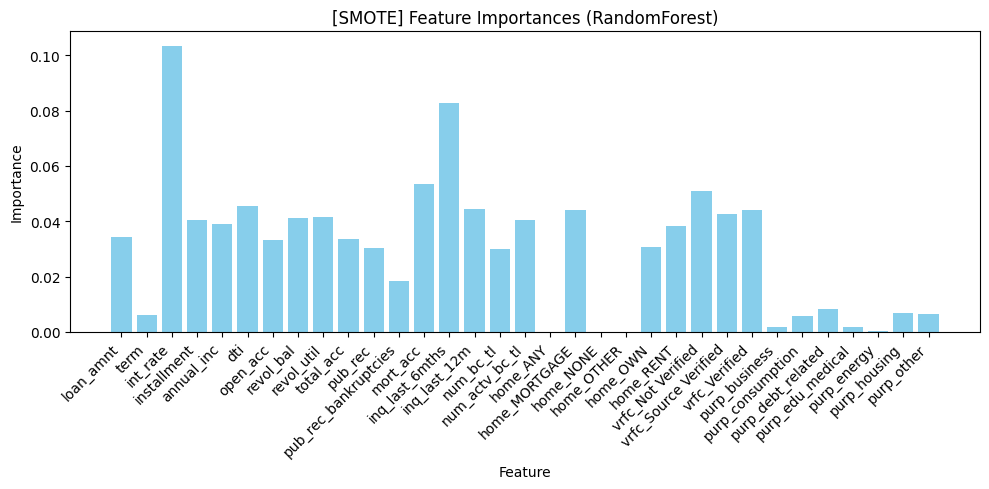

가장 중요한 변수: int_rate

[RandomUnderSampler] 성능 평가 결과:
              precision    recall  f1-score   support

           0       0.88      0.64      0.75    199806
           1       0.31      0.65      0.42     49048

    accuracy                           0.65    248854
   macro avg       0.60      0.65      0.58    248854
weighted avg       0.77      0.65      0.68    248854



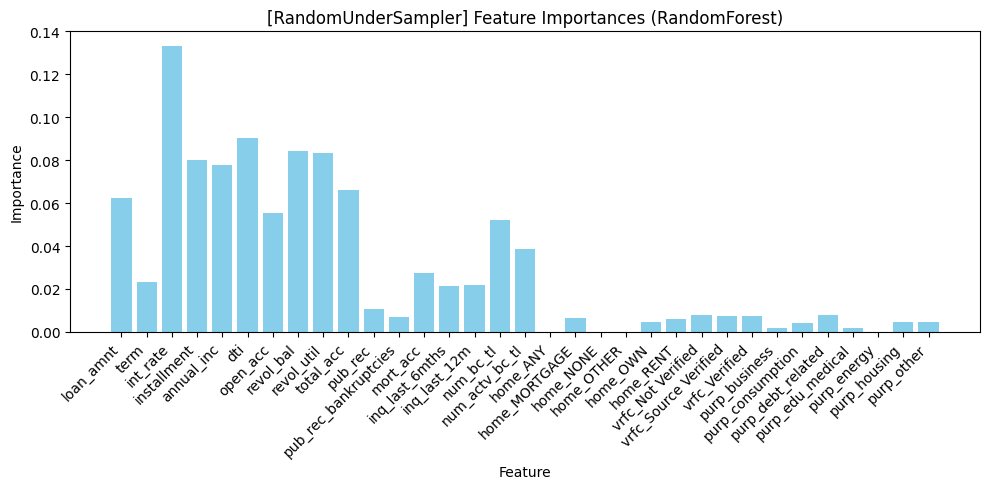

가장 중요한 변수: int_rate


In [34]:
# 1. 사용할 피처 선택 (수치형 피처 예시)

selected_features = ['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'revol_bal',
 'revol_util',
 'total_acc',
 'pub_rec',
 'pub_rec_bankruptcies',
 'mort_acc',
 'inq_last_6mths',
 'inq_last_12m',
 'num_bc_tl',
 'num_actv_bc_tl']

selected_features = acc_cleaned.drop(['emp_title', 'emp_length', 'loan_status'], axis = 1).columns

X = acc_cleaned[selected_features]
y = acc_cleaned['loan_status']  # 반드시 이 컬럼이 0(Good), 1(Default) 형태여야 함

# 2. train_test 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 42, stratify = y
    )

# 3. SMOTE 오버샘플링 적용
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("\n▶ SMOTE 적용 후 클래스 분포:")
print(y_smote.value_counts())

# 3. RandomUnderSampler 언더샘플링 적용
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print("\n▶ RandomUnderSampler 적용 후 클래스 분포:")
print(y_rus.value_counts())

# 4. 모델 학습 및 평가 + 중요도 시각화 포함 함수
def train_and_evaluate(X_train, y_train, X_test, y_test, method):
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    print(f"\n[{method}] 성능 평가 결과:")
    print(classification_report(y_test, y_pred))

    # Feature Importance 시각화
    importances = rf_model.feature_importances_
    feature_names = X_train.columns

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(importances)), importances, color='skyblue')
    plt.xticks(range(len(importances)), feature_names, rotation=45, ha='right')
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title(f"[{method}] Feature Importances (RandomForest)")
    plt.tight_layout()
    plt.show()

    # 가장 중요한 변수 출력
    most_important_idx = importances.argmax()
    most_important_feature = feature_names[most_important_idx]
    print("가장 중요한 변수:", most_important_feature)

# 7. 각각 샘플링된 데이터로 평가
train_and_evaluate(X_smote, y_smote, X_test, y_test, "SMOTE")
train_and_evaluate(X_rus, y_rus, X_test, y_test, "RandomUnderSampler")
